In [22]:
import os
import torch
from torch import optim, nn, utils
from torchvision import datasets
import torchvision.transforms as transforms
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [2]:
class ImageClassifier(L.LightningModule):

    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x) # Forward pass
        loss = self.loss_fn(logits, y)    
        self.log('train_loss', loss)
        return loss
    
    def validataion_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        # compute accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_acc', acc)
        
    
# init the model
model = ImageClassifier()

In [4]:
# Load data sets
transform = transforms.ToTensor()

train_set = datasets.MNIST(os.getcwd(), train=True, download=True, transform=transform)
test_set = datasets.MNIST(os.getcwd(), train=False, download=True, transform=transform)

# use 20% of training data for validation
train_set_size = int(len(train_set) * 0.8)
val_set_size = len(train_set) - train_set_size

# split the training set
seed = torch.Generator().manual_seed(42)
train_set, valid_set = utils.data.random_split(train_set, [train_set_size, val_set_size], generator=seed)

# create data loaders
train_loader = utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = utils.data.DataLoader(valid_set, batch_size=64, shuffle=False)
test_loader = utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

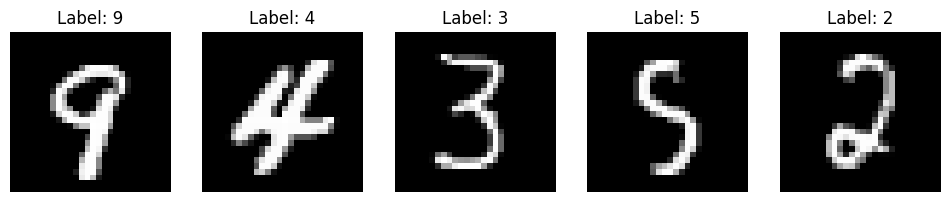

In [5]:
# sample and draw 5 data points
import matplotlib.pyplot as plt
data_iter = iter(train_loader)
images, labels = next(data_iter)
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')
plt.show()


In [ ]:
# train the model
logger = TensorBoardLogger("lightning_logs/", name="mnist_model")

trainer = L.Trainer(
    devices=[0],
    accelerator="gpu",
    # devices=4,
    # strategy="ddp_notebook",
    max_epochs=1,
    logger=logger,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jun/Research/dl/env/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type             | Params | Mode
----------------------------------------------------
0 | model   | Sequential       | 101 K  | eval
1 | loss_fn | CrossEntropyLoss | 0      | eval
----------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
/home/jun/Research/dl/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_work

Epoch 0: 100%|██████████| 750/750 [00:07<00:00, 98.26it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 750/750 [00:07<00:00, 98.13it/s, v_num=6]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/jun/Research/dl/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 145.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9786999821662903
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


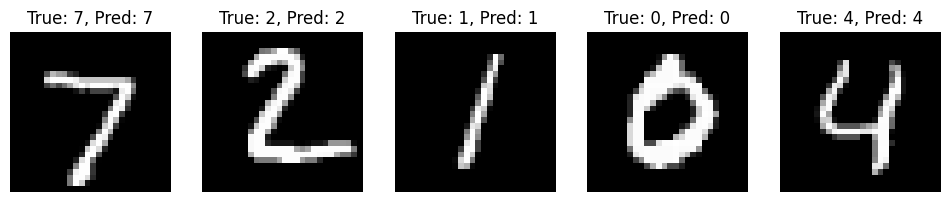

In [21]:
# create test_trainer if started a new notebook session
test_trainer = L.Trainer(
    devices=[0],
    accelerator="gpu",
    logger=False,
)

# test the model
test_trainer.test(model, dataloaders=test_loader)

# Get test data and move to same device as model
data_iter = iter(test_loader)
images, labels = next(data_iter)
logits = model(images)
preds = torch.argmax(logits, dim=1)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f'True: {labels[i].item()}, Pred: {preds[i].item()}')
    axes[i].axis('off')
plt.show()
